In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import random
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.path import Path
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
import networkx as nx

<h1>
    <b>
        Parameter UWSN
    </b>
</h1>

In [2]:
D = 1e3
P = 1e3
L = 1e3
r = 250
d_max = 1e3
base_coor = [P/2, L/2, 0]

N = 48
f = 4e4
pH = 7.7         
sh = 0.55
T = 4     
S = 34     
w = 5  
spreading_factor = 1.5
m = 10

kc = 25
kd = 250
kt = kd + N
beta = 0.8
data_rate = 500 # bps
t_transmission =  ((kd * 8)/data_rate) + ((kc * 8)/data_rate) + (((kc + N) * 8)/data_rate)
initial_energy = 0.1
E_elec = 50 * 1e-9
P_tx = 1e-9 


<h1>
    <b>
        Underwater environment
    </b>
</h1>

In [3]:
def vibrationFrequencies(show_info = False):
    f1 = 0.78 * np.sqrt(S/35) * np.exp(T/26)
    f2 = 42 * np.exp(T/17)

    if show_info: 
        print(f"F1 : {f1:.2f} | f2 : {f2:.2f}")

    return f1, f2

f1, f2 = vibrationFrequencies(show_info = False)
def attenuationConstant(D, show_info = False):
    D_km = D/1e3
    f1_kHz = f1/1e3
    f2_kHz = f2/1e3
    f_kHz = f/1e3

    term1 = 0.106 * (f1_kHz * f_kHz**2) / (f1_kHz**2 + f_kHz**2) * np.exp((pH - S) / 0.56)
    term2 = 0.52 * (1 + (T / 43)) * (S / 35) * (f2_kHz * f_kHz**2) / (f2_kHz**2 + f_kHz**2) * np.exp(-D_km / 0.56)
    term3 = 4.9e-4 * f2 * np.exp(T / 27 + D_km / 17)
    attenuation = term1 + term2 + term3
    if show_info: 
        print(f"attenuation constant: {attenuation:.2f}")

    return attenuation

def attenuation_dB(distance, show_info = False):
    att = k * np.log10(distance) + distance * attenuationConstant(show_info = True) * 1e-3
    if show_info:   
        print(f"Attenuation at distance ({distance:.2f} m) : {att:.2f} dB")
    return att

def attenuation(D, distance, show_info = False):
    att = (distance**spreading_factor) * distance * (attenuationConstant(D, show_info = False)**distance)
    if show_info:   
        print(f"Attenuation at distance ({distance:.2f} m) : {att:.2f} dB")
    return att

def noise(show_info = False):
    f_khz = f / 1e3
    turbulence_noise    = 17 - 30 * np.log10(f_khz)
    ship_noise          = 40 + 20 * (sh - 0.5) + 26 * np.log10(f_khz) - 60 * np.log10(f_khz + 0.03)
    wind_noise          =  50 + 7.5 * np.sqrt(w) + 20 * np.log10(f_khz) - 40 * np.log10(f_khz + 0.4)
    thermal_noise       =  -15 + 20 * np.log10(f_khz)

    noise_total = turbulence_noise + ship_noise + wind_noise + thermal_noise

    if show_info:   
        turbulence_noise    = round(turbulence_noise    , 2)
        ship_noise          = round(ship_noise          , 2)
        wind_noise          = round(wind_noise          , 2)
        thermal_noise       = round(thermal_noise       , 2)
        noise_total         = round(noise_total       , 2)
        print(f"Noise total : {noise_total} | Thermal noise : {thermal_noise} | Ship noise : {ship_noise} | Wind noise : {wind_noise} | Turbulence noise : {turbulence_noise} | f : {f_khz} kHz")
    return noise_total

def underwater_speed(D, show_info = False):
    D_km = D/1e3
    v_uw = 1448.96 + 4.591 * T - 5.304e-2 * T**2 + 2.374 * T**3 + 1.340 * (S - 35) + \
           1.630e-2 * D_km + 1.675e-7 * D_km**2 - 1.025e-2 * T * (S - 35) - 7.139e-13 * D_km**3 * T
    
    if show_info:
        print(f"Underwater speed at D = {D:.2f} is : {v_uw:.2f} m/s")

    return v_uw

def ratio_delay(D, distance):
    v_uw = underwater_speed(D, show_info = False)
    t_uw = distance/v_uw
    a = t_uw/t_transmission
    # print(f"Ratio delay : {a:.2f} | T_tranmission : {t_transmission:.2f} | T_uw : {t_uw:.2f}")
    return a

def throughput(a):
    numerator = kc * np.exp(-a * kc)
    denominator = kc * (1 + 2 * a) + np.exp(-a * kc)
    rho = numerator / denominator
    # print(f"Throughput : {rho:.2f} | numerator : {numerator:.2f} | denominator : {denominator:.2f}")
    return rho


<h1>
    <b>
        Arsitektur UWSN
    </b>
</h1>

In [4]:

class Node:
    def __init__(self, x, y, z, id):
        self.x = x
        self.y = y
        self.z = z
        self.energy = initial_energy
        self.nϵG = False
        self.alive = True
        self.CH = False
        self.which_cluster = 0
        self.eligible_round = 0
        self.cluster_class = 0
        self.id = id

    def distance(self, other_node):
        return np.sqrt((self.x - other_node.x)**2 + (self.y - other_node.y)**2)

    def reset(self):
        self.CH = False
        self.which_cluster = 0

    def advertisement(self, count_cluster, eligible_round):
        self.CH = True
        self.nϵG = False
        self.eligible_round = eligible_round
        self.which_cluster = count_cluster
    
    def energySelection(self, d_CH_BS, p):
        # If node selected as a CH
        a = ratio_delay(self.z, d_CH_BS)
        rho = throughput(a)
        first_term = (kc / rho) * (E_elec + P_tx * attenuation(self.z, d_CH_BS, show_info = False))
        second_term = (p * (N - 1) / rho) * (beta * E_elec * kc)
        third_term = E_elec * kt
        E_Selection = first_term + second_term + third_term
        return E_Selection

    def energyAdvertisement(self):
        # Broadcasting to all nodes in the range of d_max, occurs only for CH
        return kc * (E_elec + P_tx * attenuation(self.z, d_max, show_info = False))
    
    def energyJoin(self, p):
        # Node receive the broadcasting message and decide whether want to join as a associated node for CH i-th
        return p * N * kc * E_elec

    def energy_contention_TDMA_CH(self, Nc):
        return kc * Nc * E_elec + kt * (E_elec + P_tx * attenuation(self.z, d_max, show_info = False))
    
    def energy_contention_TDMA_Node(self, d_CH_Node):
        a = ratio_delay(self.z, d_CH_Node)
        rho = throughput(a)
        energy = (kc / rho) * (E_elec + P_tx * attenuation(self.z, d_CH_Node, show_info = False)) + ((N-1)/ rho) * kc * beta * E_elec + kt * E_elec
        return energy
    
    def energyFrame_CH(self, Nc, d_CH_BS):
        return m * Nc * kd * E_elec * beta * kd * E_elec + kd * (E_elec + P_tx * attenuation(self.z, d_CH_BS, show_info = False))
    
    def energyFrame_Node(self, d_CH_Node):
        return m * kd * E_elec * (E_elec + P_tx * attenuation(self.z, d_CH_Node, show_info = False))
    
    

def triangulation3D(show_info=False):
    d = r*np.sqrt(3)
    N_l = np.ceil((((P-d)/d) + 1))
    N_h = np.ceil(((2*np.sqrt(3)*L-6*d+4*np.sqrt(3)*r)/(3*d)) + 1)
    N_total = N_h * N_l
    dy = np.power(d, 2) - np.power(d/2, 2)
    dy = np.sqrt(dy)
    dh = ((np.sqrt(3)/2) * d) - r
    dl = d/2
    numLayer = -int(D/r)
    
    sensor_pos = {'x' : [], 'y':[], 'z':[]}
    sensor_coverage = []

    for z in range(numLayer, 0, 1):
         for x in range(0, int(N_l)):
            for y in range(0, int(N_h)):
                if y % 2 != 0:
                    # Odd
                    x_p = (d * x) 
                    y_p = dy * y
                    z_p = z * r
                    sensor_pos['x'].append(x_p)
                    sensor_pos['y'].append(y_p)
                    sensor_pos['z'].append(z_p)
                    sensor_coverage.append((x_p, y_p))
                else:
                    x_p = (d * x) + (d/2)
                    y_p = dy * y
                    z_p = z * r
                    sensor_pos['x'].append(x_p)
                    sensor_pos['y'].append(y_p)
                    sensor_pos['z'].append(z_p)
                    sensor_coverage.append((x_p, y_p))

    if show_info: 
        print(f"N_i : {N_l} | N_h : {N_h} | N_total : {N_total * -numLayer:.2f} | Num layer : {-numLayer} | d/r : {d/r:.2f} | r : {r:.2f} | d : {d:.2f} | dy : {dy:.2f} | dl : {dl:.2f} | dh : {dh:.2f}")
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(sensor_pos['x'], sensor_pos['y'], sensor_pos['z'], marker="o",color='r', edgecolors='k')
        ax.scatter(base_coor[0], base_coor[1], base_coor[2], marker="s",color='b', edgecolors='k')
 
        fig, ax = plt.subplots()
        ax.yaxis.set_major_locator(MultipleLocator(int(P//5)))
        ax.yaxis.set_major_formatter('{x:.0f}')
        ax.yaxis.set_minor_locator(MultipleLocator(int(P//10)))
        ax.xaxis.set_major_locator(MultipleLocator(int(L//5)))
        ax.xaxis.set_major_formatter('{x:.0f}')
        ax.xaxis.set_minor_locator(MultipleLocator(int(L//10)))
        ax.scatter(sensor_pos['x'], sensor_pos['y'], color='r', edgecolors=None, facecolors='None')
        verts = [
        (0., 0.),  # left, bottom
        (0., P),  # left, top
        (L, P),  # right, top
        (L, 0.),  # right, bottom
        (0., 0.),  # ignored
        ]

        codes = [
            Path.MOVETO,
            Path.LINETO,
            Path.LINETO,
            Path.LINETO,
            Path.CLOSEPOLY,
        ]

        path = Path(verts, codes)

        rect = patches.PathPatch(path, facecolor='none', lw=0.5, linestyle='--')
        ax.add_patch(rect)
        for cov in sensor_coverage:
            circle = plt.Circle(cov, r, color='k', fill=False, linewidth=0.5, linestyle='--')
            ax.add_patch(circle)
        ax.set_xlabel('Length (m)')
        ax.set_ylabel('Width (m)')
        plt.axis('equal')
    return sensor_pos



<h1>
    <b>
        Network environment model
    </b>
</h1>

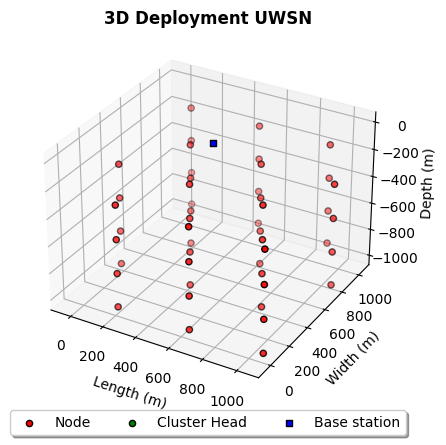


		Best number of clusters: 8 with silhouette score: 0.26985338793912617
Setup phase energy initial : 4.899999999999999


NameError: name 'k' is not defined

In [5]:
class multiHop(object):
    def __init__(self,graph):
        self.graph = graph
        self.adjacent_mat = nx.adjacency_matrix(graph).todense()
        self.num_nodes = len(self.adjacent_mat)
        self.adjacent_mat = nx.adjacency_matrix(graph, nodelist=range(self.num_nodes)).toarray()#:D
        # print(f"\n Adjacent Matrix \n{self.adjacent_mat}\n")

    def q_learning(self,start_state=0, aim_state = 10, num_epoch=200, gamma=0.8, epsilon=0.05, alpha=0.1):

        len_of_paths = []
        rewards = self.rewardMapping(aim_state)
        # print(f"\n Reward \n{rewards}\n")
        
    
        q_table = np.zeros((self.num_nodes, self.num_nodes))  # num_states * num_actions
        for episode in range(1, num_epoch + 1):
            #print(f"========================================================================== Episode : {episode} =========================================================================")
            current_state = start_state
            path = [current_state]
            len_of_path = 0
            while True:
                next_state = self.epsilon_greedy(current_state, q_table, start_state, epsilon=epsilon)
                s_next_next = self.epsilon_greedy(next_state, q_table, start_state, epsilon=-0.2)  # epsilon<0, greedy policy
                # update q_table
                reward = rewards[current_state][next_state]
                delta = reward + gamma * q_table[next_state, s_next_next] - q_table[current_state, next_state]
                
                q_table[current_state, next_state] = q_table[current_state, next_state] + alpha * delta
                # update current state
                current_state = next_state
                len_of_path += -reward
                path.append(current_state)
                # print(f"==========================\n{q_table}==========================\n")
                # print(f"reward: {reward} | Current state : {current_state} | Next state : {next_state} \n\n")


                if current_state == aim_state:
                    break
            len_of_paths.append(len_of_path)

            
        # print(f"Q learning table : \n{q_table}")
        return path

    def epsilon_greedy(self,s_curr, q, start_state, epsilon):#exploraiton vs exploitation 
        try :
            potential_next_states = np.where(np.array(self.adjacent_mat[s_curr]) > 0)[0]
        except IndexError as e:
            print(e)
            print(f"{self.adjacent_mat[s_curr]}")
        potential_next_states = potential_next_states[potential_next_states != start_state]
        # print(f"potential next state : {potential_next_states}")
        if random.random() > epsilon:  
            q_of_next_states = q[s_curr][potential_next_states]
            s_next = potential_next_states[np.argmax(q_of_next_states)]
            # print(f"q_of_next_states : {q_of_next_states}   |   s_next : {s_next}")
        else:  
            s_next = random.choice(potential_next_states)
        return s_next
    
    def rewardMapping(self, aim_state):
        r = self.adjacent_mat
        r[:, aim_state] = 100
        r[aim_state, :] = 100
        for i in range(0, len(r)):
            for j in range(0, len(r)):
                if i == j :
                    r[i][j] = -5
        return r


class networkEnvironment:
    def __init__(self):
        self.nodes = self.createNetwork()

    def createNetwork(self):
        sensor_pos = triangulation3D(show_info=False)
        nodes = []
        for index in range(0, len(sensor_pos['x'])):
            nodes.append(Node(sensor_pos['x'][index], sensor_pos['y'][index], sensor_pos['z'][index], index+1))
        nodes.append(Node(base_coor[0], base_coor[1], base_coor[2], 0))
        return nodes
        
    def showNetwork(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        nodes_x, nodes_y, nodes_z = [node.x for node in self.nodes if ((node.id != 0) and (node.CH == False))], [node.y for node in self.nodes if ((node.id != 0) and (node.CH == False))], [node.z for node in self.nodes if ((node.id != 0) and (node.CH == False))] 
        CH_x, CH_y, CH_z = [node.x for node in self.nodes if ((node.id != 0) and (node.CH == True))], [node.y for node in self.nodes if ((node.id != 0) and (node.CH == True))], [node.z for node in self.nodes if ((node.id != 0) and (node.CH == True))] 
        BS_x, BS_y, BS_z = [node.x for node in self.nodes if node.id == 0], [node.y for node in self.nodes if node.id == 0], [node.z for node in self.nodes if node.id == 0] 
        

        ax.scatter(nodes_x, nodes_y, nodes_z, marker="o",color='r', edgecolors='k', label = "Node")
        ax.scatter(CH_x, CH_y, CH_z, marker="o",color='g', edgecolors='k', label = "Cluster Head")
        ax.scatter(BS_x, BS_y, BS_z, marker="s",color='b', edgecolors='k', label="Base station")
        ax.set_xlim([-100, P+100])
        ax.set_ylim([-100, L+100])
        font = {
                'color':  'black',
                'weight': 'bold'
                }
        
        ax.set_title('3D Deployment UWSN', fontdict=font)
        ax.set_xlabel('Length (m)')
        ax.set_ylabel('Width (m)')
        ax.set_zlabel('Depth (m)')
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.005),
              fancybox=True, shadow=True, ncol=5, markerscale=1, fontsize=10)
        plt.show()

    def euclidean_distance(self, node, centroid):
        return np.sqrt(np.sum((node - centroid)**2))

    def CHselection(self):
        nodes = self.nodes
        X, Y, Z, E, id = [], [], [], [], []
        for node in nodes:
            if node != 0 :
                # Isnt cluster head
                X.append(node.x)
                Y.append(node.y)
                Z.append(node.z)
                E.append(node.energy)
                id.append(node.id)
        
        data = np.array([X, Y, Z, E]).T
        scaler = StandardScaler()
        standardized_data = scaler.fit_transform(data)
        best_score = -1
        best_k = 0

        for k in range(2, 10 + 1):
            kmeans = KMeans(n_clusters=k, random_state=42)
            cluster_labels = kmeans.fit_predict(standardized_data)
            score = silhouette_score(standardized_data, cluster_labels)
            
            if score > best_score:
                best_score = score
                best_k = k
                centroids = kmeans.cluster_centers_

        print(f"\n\t\tBest number of clusters: {best_k} with silhouette score: {best_score}")

        kmeans = KMeans(n_clusters=best_k, random_state=42)
        kmeans = kmeans.fit(standardized_data)
        centroids = kmeans.cluster_centers_
        centroids = scaler.inverse_transform(centroids)
        CH_selected = []
        for j in range(best_k):
            distances = [[], []]
            for node in nodes:
                if node != 0 :
                    X = np.array([node.x, node.y, node.z, node.energy])
                    distances[0].append(self.euclidean_distance(X, centroids[j]))
                    distances[1].append(node.id)
            CH_selected.append(distances[1][np.argmin(distances[0])])

        count = 1
        for id in CH_selected:
            for node in nodes:
                if ((node.id == id) and (node.id != 0)):
                    node.CH = True
                    node.which_cluster = count 
            count += 1

        CHs = [node for node in nodes if node.CH == True]        
        for node in nodes:
            if node.id != 0:
                distances = [[], []]
                for ch in CHs:
                    X = np.array([node.x, node.y, node.z, node.energy])
                    CH = np.array([ch.x, ch.y, ch.z, ch.energy])
                    distances[0].append(self.euclidean_distance(X, CH))
                    distances[1].append(ch.which_cluster)
                node.which_cluster = distances[1][np.argmin(distances[0])]
        return best_k
    
    def Nc(self, which_cluster):
        count = 0
        for node in self.nodes:
            if node.which_cluster == which_cluster:
                count += 1
        return count

    def setup(self):
        self.k = self.CHselection()
        energy_total = sum([node.energy for node in self.nodes])
        print(f"Setup phase energy initial : {energy_total}")
        for node in self.nodes:
            if node.id != 0:
                if node.CH:
                    d_CH_BS = self.euclidean_distance(np.array([node.x, node.y, node.z]), np.array(base_coor))
                    energy_dissipated = node.energyAdvertisement() + node.energySelection(d_CH_BS, self.k/N)
                    node.energy = node.energy - energy_dissipated
                else:
                    node.energy = node.energy - node.energyJoin(k/N)
        energy_total = sum([node.energy for node in self.nodes])
        print(f"Setup phase energy after : {energy_total}")

    def steadyState(self):
        energy_total = sum([node.energy for node in self.nodes])
        print(f"Contention phase energy initial : {energy_total:.2f}")
        for node in self.nodes:
            if node.id != 0 :
                if node.CH == True:
                    Nc = self.Nc(node.which_cluster)
                    node.energy = node.energy - node.energy_contention_TDMA_CH(Nc)
                else:
                    CH = [ch for ch in self.nodes if node.which_cluster==ch.which_cluster][0]
                    d_CH_Node = self.euclidean_distance(np.array([node.x, node.y, node.z]), np.array([CH.x, CH.y, CH.z]))
                    node.energy = node.energy - node.energy_contention_TDMA_Node(d_CH_Node)
        energy_total = sum([node.energy for node in self.nodes])
        print(f"Transmission energy begin : {energy_total:.2f}")
        for node in self.nodes:
            if node.id != 0 :
                if node.CH == True:
                    Nc = self.Nc(node.which_cluster)
                    node.energy = node.energy - node.energy_contention_TDMA_CH(Nc)
                    self.multiHopRouting(node.id)
                    print(f"Id : {node.id}")
                else:
                    CH = [ch for ch in self.nodes if node.which_cluster==ch.which_cluster][0]
                    d_CH_Node = self.euclidean_distance(np.array([node.x, node.y, node.z]), np.array([CH.x, CH.y, CH.z]))
                    node.energy = node.energy - node.energy_contention_TDMA_Node(d_CH_Node)

            if node.energy<0:
                print("dead node")

    def multiHopRouting(self, clusterHead_id):
        CHs = [node for node in self.nodes if node.id == 0] + [node for node in self.nodes if node.CH == True]
        CHsID = np.array([node.id for node in CHs])
        start_state = np.where(np.isin(CHsID, clusterHead_id))[0][0]
        print(f"Start state : {start_state}")
        edges = []
        X, Y, Z, E, id = [], [], [], [], []
        for ch in CHs:
            X.append(ch.x)
            Y.append(ch.y)
            Z.append(ch.z)
            E.append(ch.energy)
            id.append(ch.id)
        
        distance = np.array([X, Y, Z]).T
        E = np.array(E).T
        # scaler = StandardScaler()
        # standardized_data = scaler.fit_transform(data)
        G = nx.Graph()
        for i in range(0, self.k+1):
            for j in range(0, self.k+1):
                if i != j:
                    distance_normalized = self.euclidean_distance(distance[i, :], distance[j, :])/np.mean(distance)
                    energy_normalized = E[j]/np.mean(E) 
                    weight = 1/distance_normalized + energy_normalized
                    # print(f"{(i, j, distance_normalized, energy_normalized, weight)}")
                    edges.append((i,j, weight))
        for start, end, length in edges:
            # You can attach any attributes you want when adding the edge
            G.add_edge(start, end, weight=length)
        
        # plt.figure(figsize=(12,12)) 
        # nx.draw(G, with_labels=True,node_size=2500,font_size=32)
        # plt.show()
        map = multiHop(G)
        paths = map.q_learning(start_state=start_state, aim_state = 0, num_epoch=10000, gamma=0.8, epsilon=0.05, alpha=0.1)#start_state=0,aim_state = 10
        ID_path = []
        for path in paths:
            ID_path.append(CHsID[path])
        print(f"ID ; {ID_path} | path : {paths}")

network = networkEnvironment()
network.showNetwork()
network.setup()
network.steadyState()
network.showNetwork()


In [ ]:
a = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
b = [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]
c = [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]

d = np.array([a,b,c]).T
d

array([[10, 40, 20],
       [11, 41, 21],
       [12, 42, 22],
       [13, 43, 23],
       [14, 44, 24],
       [15, 45, 25],
       [16, 46, 26],
       [17, 47, 27],
       [18, 48, 28],
       [19, 49, 29],
       [20, 50, 30],
       [21, 51, 31],
       [22, 52, 32]])

In [ ]:
a = np.array([2,3,4,5,6])
np.where(np.isin(a, 5))[0][0]

3